In [7]:
import logging
from time import time as get_time
from datetime import date
import torch as th
import numpy as np
from scipy.linalg import eigh
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.switch_backend('agg')


from ClsQuantumDynamics import QuantumDynamics as clsQD
from neural_net import neel_state
from config import deepqd_config

from hilbert import hilbert_xxz
from util import *
import pickle

nspin = 16
sz = 0
# hz = np.ones(nspin) / nspin
# hz = np.random.random(nspin) / nspin
# hz = np.cos(2*np.arange(nspin)+1.789) / nspin
hz = np.zeros(nspin)
config = deepqd_config(nspin=nspin, sz=sz, hz = hz, dc = 1)
hilbert = hilbert_xxz(config)
clsqd = clsQD(config)
H = clsqd.get_hamiltonian()


In [ ]:
####plot spin-density wave
dc_list = [2,8]
for dc in dc_list:
    config = deepqd_config(nspin=nspin, sz=sz, hz = hz, dc = dc)
    hilbert = hilbert_xxz(config)
    init_state = neel_state(hilbert, config.neel_peak, sz_sum=sz)
    T = 60
    time_step = 60
    time = np.arange(time_step) / time_step * T
    clsqd = clsQD(config)
    clsqd.initialize(init_state)
    time_cls, entropy, nn_coupling, spin_imbalance, spin_density_cls = clsqd.get_spin_density_evolution(T)
#     time_cls, spin_density_cls = clsqd.get_spin_density_evolution(T)
    ## spin wave
    fig = plt.figure()
    for i in range(config.num_spin) :
        plt.plot(time_cls, spin_density_cls[:,i])#, label='spin '+str(i)+'vanilla')
    plt.xlabel('time')
    plt.ylabel('spin density')
    plot_dir  = "./plot_data/homos{}dc{}T{}.png".format(config.num_spin, config.amplitude_decay, T)
    plt.savefig(plot_dir)
    plt.close()
    ## entropy 
    fig = plt.figure()
    plt.plot(time_cls, entropy)#, label='spin '+str(i)+'vanilla')
    plt.xlabel('time')
    plt.ylabel('entropy')
    plot_dir  = "./plot_data/homos{}dc{}T{}-entropy.png".format(config.num_spin, config.amplitude_decay, T)
    plt.savefig(plot_dir)
    plt.close()
    ## imbalance
    fig = plt.figure()
    plt.plot(time_cls, spin_imbalance)#, label='spin '+str(i)+'vanilla')
    plt.xlabel('time')
    plt.ylabel('spin_imbalance')
    plot_dir  = "./plot_data/homos{}dc{}T{}-spin_imbalance.png".format(config.num_spin, config.amplitude_decay, T)
    plt.savefig(plot_dir)
    plt.close()
    ## nn-coupling
    fig = plt.figure()
    plt.plot(time_cls, nn_coupling)#, label='spin '+str(i)+'vanilla')
    plt.xlabel('time')
    plt.ylabel('ss')
    plot_dir  = "./plot_data/homos{}dc{}T{}-nn_coupling.png".format(config.num_spin, config.amplitude_decay, T)
    plt.savefig(plot_dir)
    plt.close()
    
    
    plot_data_dir = "./plot_data/homos{}dc{}T{}.data".format(config.num_spin, config.amplitude_decay, T)
    with open(plot_data_dir,"wb") as file:
        pickle.dump(time_cls, file)
        pickle.dump(spin_density_cls, file)
        pickle.dump(entropy, file)
        pickle.dump(nn_coupling, file)
        pickle.dump(spin_imbalance, file)

In [48]:
## tenpy calculation
## TDVP

"""Example illustrating the use of TDVP in tenpy.

As of now, we have TDVP only for finite systems. The call structure is quite similar to TEBD. A
difference is that we can run one-site TDVP or two-site TDVP. In the former, the bond dimension can
not grow; the latter allows to grow the bond dimension and hence requires a truncation.
"""
# Copyright 2019-2020 TeNPy Developers, GNU GPLv3
import numpy as np
import tenpy.linalg.np_conserved as npc
import tenpy.models.spins
from tenpy.models.spins import SpinModel
import tenpy.networks.mps as mps
import tenpy.networks.site as site
from tenpy.algorithms import tdvp
from tenpy.networks.mps import MPS
from tenpy.linalg.np_conserved import inner as inner
import copy
import matplotlib.pyplot as plt
import pickle
def tdvp_xxz1d(Jt, L,Jz,chi,pbc = 'periodic'):
    delta_t = 0.025
    steps = int(Jt/delta_t)
    time = np.arange(steps) * delta_t
    model_params = {
        "S": 0.5,  # Spin 1/2
        "lattice": "Chain",
        "bc_MPS": "finite",
        "bc_x": pbc,
        "L": L,
        # "hz": 0.5,
        "conserve": "Sz",  # use Sz conservation
        "Jx": 1.,
        "Jy": 1.,
        "Jz": Jz,  # Heisenberg coupling
        "verbose": True,
        }
    heisenberg = SpinModel(model_params)
#     product_state = ['down','up'] * (L//2) + ['down']*(L%2)
    product_state = ["down"] * (L // 4) + ["up"] * (L // 2) + ["down"] * (L // 4)
    # starting from a domain-wall product state which is not an eigenstate of the Heisenberg model
    psi0 = MPS.from_product_state(heisenberg.lat.mps_sites(),
                                 product_state,
                                 bc=heisenberg.lat.bc_MPS,
                                 form='B')
    psi = MPS.from_product_state(heisenberg.lat.mps_sites(),
                                 product_state,
                                 bc=heisenberg.lat.bc_MPS,
                                 form='B')
    tdvp_params = {
        'start_time': 0,
        'dt': delta_t,
        'trunc_params': {
            'chi_max': chi,
            'svd_min': 1.e-10,
            'trunc_cut': None
        }
    }
    tdvp_engine = tdvp.Engine(psi=psi, model=heisenberg, options =tdvp_params)
    times = []
    S_mid = []
    echo = []
    spin_density = []
    for i in range(steps):
        tdvp_engine.run_two_sites(N_steps=1)
        times.append(tdvp_engine.evolved_time)
        S_mid.append(psi.entanglement_entropy(bonds=[L // 2])[0])
        echo.append([0])
        # echo.append(inner(psi0,psi,do_conj=True))

        print('t={},s={},echo={}'.format(times[-1],S_mid[-1],echo[-1]))
        # print(psi.expectation_value("Sz"))
        spin_density.append(psi.expectation_value("Sz"))

    spin_density = np.array(spin_density) * 2
    entropy = np.array(S_mid)
    spin_imbalance = spin_density[:,1::2].sum(1)-spin_density[:,0::2].sum(1)
    
    plt.figure()
    for i in range(spin_density.shape[1]):
        plt.plot(times, spin_density[:,i])
    plt.xlabel('t')
    plt.ylabel('Sz')
    filename = './benchmark/1dxxz_L{}bc{}_spindensity_chi{}.png'.format(L,pbc,chi)
    plt.savefig(filename)
    plt.close()

    plt.figure()
    plt.plot(times, spin_imbalance)
    plt.xlabel('t')
    plt.ylabel('imbalance')
    filename = './benchmark/1dxxz_L{}bc{}_imbalance_chi{}.png'.format(L,pbc,chi)
    plt.savefig(filename)
    plt.close()

    plt.figure()
    plt.plot(times, entropy)
    plt.xlabel('t')
    plt.ylabel('EE_middle')
    filename = './benchmark/1dxxz_L{}bc{}_ee_chi{}.png'.format(L,pbc,chi)
    plt.savefig(filename)
    plt.close()

#     plt.figure()
#     plt.plot(times, echo)
#     plt.xlabel('t')
#     plt.ylabel('echo')
#     filename = './plot_data/1dxxz_L{}bc{}_echo_chi{}.png'.format(L,pbc,chi)
#     plt.savefig(filename)
#     plt.close()
    return time, spin_density, entropy, np.zeros_like(entropy), spin_imbalance
def tdvp_xxz2d(L,Jz,chi,pbc = 'periodic'):
    size = L**2
    delta_t = 0.02
    model_params = {
        "S": 0.5,  # Spin 1/2
        "lattice": "Square",
        "bc_MPS": "finite",
        "bc_x": pbc,
        "bc_y": "cylinder",
        "Lx": L,
        "Ly": L,  # defines cylinder circumference
        # "hz": 0.5,
        "conserve": "Sz",  # use Sz conservation
        "Jx": 1.,
        "Jy": 1.,
        "Jz": Jz,  # Heisenberg coupling
        "verbose": True,
        }
    heisenberg = SpinModel(model_params)
    product_state = (["down",'up'] * size)[:size]   # initial Neel state
    # product_state = ["up"] * (L // 2) + ["down"] * (L - L // 2)
    # starting from a domain-wall product state which is not an eigenstate of the Heisenberg model
    psi = MPS.from_product_state(heisenberg.lat.mps_sites(),
                                 product_state,
                                 bc=heisenberg.lat.bc_MPS,
                                 form='B')
    tdvp_params = {
        'start_time': 0,
        'dt': delta_t,
        'trunc_params': {
            'chi_max': chi,
            'svd_min': 1.e-10,
            'trunc_cut': None
        }
    }
    tdvp_engine = tdvp.Engine(psi=psi, model=heisenberg, TDVP_params=tdvp_params)
    times = []
    S_mid = []
    spin_density = []
    for i in range(120):
        tdvp_engine.run_two_sites(N_steps=1)
        times.append(tdvp_engine.evolved_time)
        S_mid.append(psi.entanglement_entropy(bonds=[size // 2])[0])
        # S_mid.append(psi.entanglement_entropy())
        print('t={},s={}'.format(times[-1],S_mid[-1]))
        print('chi=',psi.chi)
        # print(psi.expectation_value("Sz"))
        spin_density.append(psi.expectation_value("Sz"))
    # for i in range(60):
    #     tdvp_engine.run_one_site(N_steps=1)
    #     #psi_2=copy.deepcopy(psi)
    #     #psi_2.canonical_form()
    #     times.append(tdvp_engine.evolved_time)
    #     S_mid.append(psi.entanglement_entropy(bonds=[L // 2])[0])
    #     print('t={},s={}'.format(times[-1],S_mid[-1]))
    #     print(psi.expectation_value("Sz"))"))
    
    #     spin_density.append(psi.expectation_value("Sz
    spin_density = np.array(spin_density) * 2
    
    plt.figure()
    for i in range(spin_density.shape[1]):
        plt.plot(times, spin_density[:,i])
    plt.xlabel('t')
    plt.ylabel('Sz')
    filename = './plot/2dxxz_L{}bc{}_spindensity_chi{}.png'.format(L,pbc,chi)
    plt.savefig(filename)
    plt.close()

    plt.figure()
    for i in range(spin_density.shape[1]):
        plt.plot(times, S_mid)
    plt.xlabel('t')
    plt.ylabel('EE_middle')
    filename = './plot/2dxxz_L{}bc{}_ee_chi{}.png'.format(L,pbc,chi)
    plt.savefig(filename)
    plt.close()



In [49]:
L = 32
T = 320
time_cls, spin_density_cls, entropy, nn_coupling, spin_imbalance =  tdvp_xxz1d(
    Jt=T/L,L=L,Jz=-1,chi=256,pbc='periodic')
plot_data_dir = "./benchmark/wallJz-1L{}T{}.tenpy".format(L,T/L)
with open(plot_data_dir,"wb") as file:
    pickle.dump(time_cls, file)
    pickle.dump(entropy, file)
    pickle.dump(nn_coupling, file)
    pickle.dump(spin_imbalance, file)
    pickle.dump(spin_density_cls, file)


Reading 'lattice'='Chain' for config SpinModel
Reading 'bc_MPS'='finite' for config SpinModel
Reading 'S'=0.5 for config SpinModel
Reading 'conserve'='Sz' for config SpinModel
Reading 'bc_x'='periodic' for config SpinModel
Reading 'L'=32 for config SpinModel
Reading 'Jx'=1.0 for config SpinModel
Reading 'Jy'=1.0 for config SpinModel
Reading 'Jz'=-1 for config SpinModel
Reading 'start_time'=0 for config TDVP
Reading 'dt'=0.025 for config TDVP
Subconfig 'trunc_params'=Config(<4 options>, 'trunc_params') for config TDVP
t=0.025,s=-0.0,echo=[0]
t=0.05,s=-0.0,echo=[0]
t=0.07500000000000001,s=-0.0,echo=[0]
t=0.1,s=-0.0,echo=[0]
t=0.125,s=-0.0,echo=[0]
t=0.15,s=-0.0,echo=[0]
t=0.175,s=-0.0,echo=[0]
t=0.19999999999999998,s=-0.0,echo=[0]
t=0.22499999999999998,s=-0.0,echo=[0]
t=0.24999999999999997,s=-0.0,echo=[0]
t=0.27499999999999997,s=-0.0,echo=[0]
t=0.3,s=-0.0,echo=[0]
t=0.325,s=-0.0,echo=[0]
t=0.35000000000000003,s=-0.0,echo=[0]
t=0.37500000000000006,s=-0.0,echo=[0]
t=0.4000000000000001,s=-0

In [42]:

spin_density_cls.shape


(120, 16)

In [10]:
# Ground energy with DMRG

import numpy as np

from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.models.spins import SpinModel
from tenpy.algorithms import dmrg


def example_DMRG_tf_ising_finite(L, g, verbose=True):
    print("finite DMRG, transverse field Ising model")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    model_params = dict(L=L, J=1., g=g, bc_MPS='finite', conserve=None, verbose=verbose)
    M = TFIChain(model_params)
    product_state = ["up"] * M.lat.N_sites
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': None,  # setting this to True helps to escape local minima
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': 30,
            'svd_min': 1.e-10
        },
        'verbose': verbose,
        'combine': True
    }
    info = dmrg.run(psi, M, dmrg_params)  # the main work...
    E = info['E']
    print("E = {E:.13f}".format(E=E))
    print("final bond dimensions: ", psi.chi)
    mag_x = np.sum(psi.expectation_value("Sigmax"))
    mag_z = np.sum(psi.expectation_value("Sigmaz"))
    print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    if L < 20:  # compare to exact result
        from tfi_exact import finite_gs_energy
        E_exact = finite_gs_energy(L, 1., g)
        print("Exact diagonalization: E = {E:.13f}".format(E=E_exact))
        print("relative error: ", abs((E - E_exact) / E_exact))
    return E, psi, M


def example_1site_DMRG_tf_ising_finite(L, g, verbose=True):
    print("single-site finite DMRG, transverse field Ising model")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    model_params = dict(L=L, J=1., g=g, bc_MPS='finite', conserve=None, verbose=verbose)
    M = TFIChain(model_params)
    product_state = ["up"] * M.lat.N_sites
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': True,  # setting this to True is essential for the 1-site algorithm to work.
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': 30,
            'svd_min': 1.e-10
        },
        'verbose': verbose,
        'combine': False,
        'active_sites': 1  # specifies single-site
    }
    info = dmrg.run(psi, M, dmrg_params)
    E = info['E']
    print("E = {E:.13f}".format(E=E))
    print("final bond dimensions: ", psi.chi)
    mag_x = np.sum(psi.expectation_value("Sigmax"))
    mag_z = np.sum(psi.expectation_value("Sigmaz"))
    print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    if L < 20:  # compare to exact result
        from tfi_exact import finite_gs_energy
        E_exact = finite_gs_energy(L, 1., g)
        print("Exact diagonalization: E = {E:.13f}".format(E=E_exact))
        print("relative error: ", abs((E - E_exact) / E_exact))
    return E, psi, M


def example_DMRG_tf_ising_infinite(g, verbose=True):
    print("infinite DMRG, transverse field Ising model")
    print("g={g:.2f}".format(g=g))
    model_params = dict(L=2, J=1., g=g, bc_MPS='infinite', conserve=None, verbose=verbose)
    M = TFIChain(model_params)
    product_state = ["up"] * M.lat.N_sites
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': True,  # setting this to True helps to escape local minima
        'trunc_params': {
            'chi_max': 30,
            'svd_min': 1.e-10
        },
        'max_E_err': 1.e-10,
        'verbose': verbose,
    }
    # Sometimes, we want to call a 'DMRG engine' explicitly
    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    E, psi = eng.run()  # equivalent to dmrg.run() up to the return parameters.
    print("E = {E:.13f}".format(E=E))
    print("final bond dimensions: ", psi.chi)
    mag_x = np.mean(psi.expectation_value("Sigmax"))
    mag_z = np.mean(psi.expectation_value("Sigmaz"))
    print("<sigma_x> = {mag_x:.5f}".format(mag_x=mag_x))
    print("<sigma_z> = {mag_z:.5f}".format(mag_z=mag_z))
    print("correlation length:", psi.correlation_length())
    # compare to exact result
    from tfi_exact import infinite_gs_energy
    E_exact = infinite_gs_energy(1., g)
    print("Analytic result: E (per site) = {E:.13f}".format(E=E_exact))
    print("relative error: ", abs((E - E_exact) / E_exact))
    return E, psi, M


def example_1site_DMRG_tf_ising_infinite(g, verbose=True):
    print("single-site infinite DMRG, transverse field Ising model")
    print("g={g:.2f}".format(g=g))
    model_params = dict(L=2, J=1., g=g, bc_MPS='infinite', conserve=None, verbose=verbose)
    M = TFIChain(model_params)
    product_state = ["up"] * M.lat.N_sites
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': True,  # setting this to True is essential for the 1-site algorithm to work.
        'trunc_params': {
            'chi_max': 30,
            'svd_min': 1.e-10
        },
        'max_E_err': 1.e-10,
        'verbose': verbose,
        'combine': True
    }
    eng = dmrg.SingleSiteDMRGEngine(psi, M, dmrg_params)
    E, psi = eng.run()  # equivalent to dmrg.run() up to the return parameters.
    print("E = {E:.13f}".format(E=E))
    print("final bond dimensions: ", psi.chi)
    mag_x = np.mean(psi.expectation_value("Sigmax"))
    mag_z = np.mean(psi.expectation_value("Sigmaz"))
    print("<sigma_x> = {mag_x:.5f}".format(mag_x=mag_x))
    print("<sigma_z> = {mag_z:.5f}".format(mag_z=mag_z))
    print("correlation length:", psi.correlation_length())
    # compare to exact result
    from tfi_exact import infinite_gs_energy
    E_exact = infinite_gs_energy(1., g)
    print("Analytic result: E (per site) = {E:.13f}".format(E=E_exact))
    print("relative error: ", abs((E - E_exact) / E_exact))


def example_DMRG_heisenberg_xxz_finite(L,Jz, sign=1, conserve='Sz', verbose=True):
    print("infinite DMRG, Heisenberg XXZ chain")
    print("Jz={Jz:.2f}, conserve={conserve!r}".format(Jz=Jz, conserve=conserve))
    model_params = {
        "S": 0.5,  # Spin 1/2
        "lattice": "Chain",
        "bc_MPS": "finite",
        "bc_x": 'periodic',
        "L": L,
        "hz": sign * 4 * np.sin(0.5+2*np.arange(L)),
        "conserve": "Sz",  # use Sz conservation
        
        "Jx": sign*1.,
        "Jy": sign*1.,
        "Jz": sign*Jz,  # Heisenberg coupling
        "verbose": True,
        }
    M = SpinModel(model_params)
    product_state = (["up", "down"] * L)[:L]  # initial Neel state
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': True,  # setting this to True helps to escape local minima
        'trunc_params': {
            'chi_max': 100,
            'svd_min': 1.e-10,
        },
        'max_E_err': 1.e-10,
        'verbose': verbose,
    }
    info = dmrg.run(psi, M, dmrg_params)
    E = info['E']
    print("E = {E:.13f}".format(E=E/L))
    print("final bond dimensions: ", psi.chi)
    Sz = psi.expectation_value("Sz")  # Sz instead of Sigma z: spin-1/2 operators!
    mag_z = np.mean(Sz)
    print("<S_z> = [{Sz0:.5f}, {Sz1:.5f}]; mean ={mag_z:.5f}".format(Sz0=Sz[0],
                                                                     Sz1=Sz[1],
                                                                     mag_z=mag_z))
    # note: it's clear that mean(<Sz>) is 0: the model has Sz conservation!
    # print("correlation length:", psi.correlation_length())
    # corrs = psi.correlation_function("Sz", "Sz", sites1=range(10))
    # print("correlations <Sz_i Sz_j> =")
    # print(corrs)
    return E, psi, M


if __name__ == "__main__":
    # example_DMRG_tf_ising_finite(L=10, g=1., verbose=True)
    # print("-" * 100)
    # example_1site_DMRG_tf_ising_finite(L=10, g=1., verbose=True)
    # print("-" * 100)
    # example_DMRG_tf_ising_infinite(g=1.5, verbose=True)
    # print("-" * 100)
    # example_1site_DMRG_tf_ising_infinite(g=1.5, verbose=True)
    # print("-" * 100)
    # example_DMRG_heisenberg_xxz_finite(16,Jz=2)
    # example_DMRG_heisenberg_xxz_finite(50,Jz=-1,sign=1)
    example_DMRG_heisenberg_xxz_finite(40,Jz=1,sign=1)


infinite DMRG, Heisenberg XXZ chain
Jz=1.00, conserve='Sz'
Reading 'lattice'='Chain' for config SpinModel
Reading 'bc_MPS'='finite' for config SpinModel
Reading 'S'=0.5 for config SpinModel
Reading 'conserve'='Sz' for config SpinModel
Reading 'bc_x'='periodic' for config SpinModel
Reading 'L'=40 for config SpinModel
Reading 'Jx'=1.0 for config SpinModel
Reading 'Jy'=1.0 for config SpinModel
Reading 'Jz'=1 for config SpinModel
Reading 'hz'=array([ 1.91770215,  2.39388858, -3.91012047,  0.86047995,  3.19394845,
       -3.51878304, -0.26528759,  3.73958022, -2.84714137, -1.36992247,
        3.98731918, -1.94869805, -2.36543012,  3.91743057, -0.89502256,
       -3.17250896,  3.53548169,  0.22994991, -3.72686755,  2.87189837,
        1.33660471, -3.98434601,  1.97954127,  2.33678634, -3.92443375,
        0.92949505,  3.15082091, -3.55190335, -0.19459422,  3.71386289,
       -2.89643037, -1.30318222,  3.98106069, -2.0102294 , -2.30795948,
        3.93112947, -0.96389471, -3.128886  ,  3.5680

In [2]:
from hilbert import *
from matplotlib import pyplot as plt
import pickle
def benchmark(L=16,Jt=6,stype='wall'):
    model_paras = {
            'dim': 1,
            'device' : 'cpu',
            'dtype' : th.float,
            'Lx' : L,
            'Jx' : 1/L,
            'Jz' : -1/L,
            'hz' : th.zeros(L),
            'conserve':'Sz',
            'sz_conserve': 0,
            'pbc_x': True,
        }
    ham = heisenberg(model_paras)
    if stype == 'neel':
        reference = th.tensor([-1,1]*(L//2))
    elif stype == 'wall':
        reference = th.tensor([-1]*(L//2)+[1]*(L//2))
    time, entropy, szsz_avg, stagger_avg, sdw_avg = ham.get_exact_observation(Jt*L, reference)
    return time, entropy, szsz_avg, stagger_avg, sdw_avg



norm(a) tensor(1.0000)


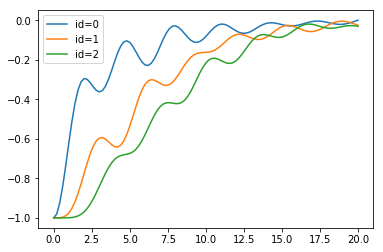

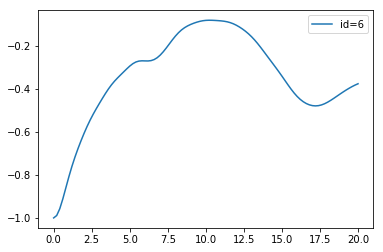

In [31]:
ax1= plt.figure(1)
ax2= plt.figure(2)
for L in [14]:
    time, entropy, szsz_avg, stagger_avg, sdw_avg = benchmark(L=L,Jt=20)
    with open('./benchmark/wallJz-1L{}.npy'.format(L),"wb") as file:
        pickle.dump(time/L, file)
        pickle.dump(entropy, file)
        pickle.dump(szsz_avg, file)
        pickle.dump(stagger_avg, file)
        pickle.dump(sdw_avg, file)
    plt.figure(1)
    for idx,sdw in enumerate(sdw_avg.transpose()):
        if idx < 3:
            plt.plot(time/L, sdw,label='id={}'.format(idx))
    plt.legend()
    plt.figure(2)
    for idx,szsz in enumerate(szsz_avg.transpose()):
        if idx == (L//2-1):
            plt.plot(time/L, szsz, label='id={}'.format(idx)) 
    plt.legend()

In [21]:
plt.close('all')